In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from implementations import * 
from utilities.logistic_regression import * #todo specify with the ones we use
from utilities.linear_regression import * #todo specify with the ones we use

In [2]:
# Load the dataset, sub-sampled
x_tr_original, x_te_original, y_tr, tr_id, te_id = load_csv_data('dataset', sub_sample=False)
# Transform our y values from {-1,1} to {0,1} because that’s what logistic regression tests expect https://edstem.org/eu/courses/1605/discussion/134447
y_tr[y_tr == -1] = 0

In [3]:
# Make a copy so we can just rerun this cell to start over instead of re-loading the dataset from disk, which is long
x_tr = x_tr_original
x_te = x_te_original

### Data exploration and data cleaning

In [4]:
'''
We observe the data to find any imbalance in the target class representation
'''
class_imbalance = np.unique(y_tr, return_counts=True)
print(class_imbalance)
print('Percentage of samples that did not have MICHD: {}'.format(class_imbalance[1][0] / len(y_tr)))
print('Percentage of samples that had MICHD: {}'.format(class_imbalance[1][1] / len(y_tr)))

(array([0, 1]), array([299160,  28975]))
Percentage of samples that did not have MICHD: 0.911697929205967
Percentage of samples that had MICHD: 0.08830207079403295


In [5]:
'''
The most important class of samples is highly under-represented. 
Our predictions should focus on finding True Positives rather than True Negatives, 
even at the expense of a higher False Positive rate. The reason for that is that the cost
of not finding True Positives is very high (not predicting MICHD) while we can afford the 
cost of some False Positives.

To correct this imbalance, we under-sample the majority class (Negative) 
and over-sample the minority class (Positive) until we reach an equal ratio.

'''
def balance_dataset(x_tr, y_tr): #todo clean et j'ai utilisé chatGPT, le masquer
    '''
    Balances the dataset to correct under-representation of the positive minority class (patients that had MICHD)
    With M <= N:
    Args:
        x_tr: numpy array of shape (N,D), D is the number of features.
        y_tr: numpy array of shape (N,D), D is the number of features.
    Returns:
        x_tr_balanced: numpy array of shape (M,D), x_tr with an equal amount of positive and negative class samples
        y_tr_balanced: numpy array of shape (M,D), y_tr with an equal amount of positive and negative class samples
    '''
    
    # Masks for negative (majority) and positive (minority) classes
    mask_negative = y_tr == 0  
    mask_positive = y_tr == 1 
    
    X_negative, y_negative = x_tr[mask_negative], y_tr[mask_negative]
    X_positive, y_positive = x_tr[mask_positive], y_tr[mask_positive]
    
    num_negative = len(y_negative)
    num_positive = len(y_positive)
    
    #Undersampling the Majority Class todo technique de barbare, on dégage tellement de data... changer
    
    num_samples_to_keep = len(y_positive) # we keep as many samples as the minority class
    
    negative_indices = np.random.choice(len(y_negative), num_samples_to_keep, replace=False)
    X_negative_undersampled = X_negative[negative_indices]
    y_negative_undersampled = y_negative[negative_indices]
    
    X_balanced = np.vstack([X_negative_undersampled, X_positive])
    y_balanced = np.hstack([y_negative_undersampled, y_positive])
    
    shuffle_indices = np.random.permutation(len(y_balanced))
    x_tr_balanced = X_balanced[shuffle_indices]
    y_tr_balanced = y_balanced[shuffle_indices]
    
    print("Class distribution after undersampling:")
    print("Class 0:", np.sum(y_tr_balanced == 0))
    print("Class 1:", np.sum(y_tr_balanced == 1))
    return x_tr_balanced, y_tr_balanced

x_tr, y_tr = balance_dataset(x_tr, y_tr)

Class distribution after undersampling:
Class 0: 28975
Class 1: 28975


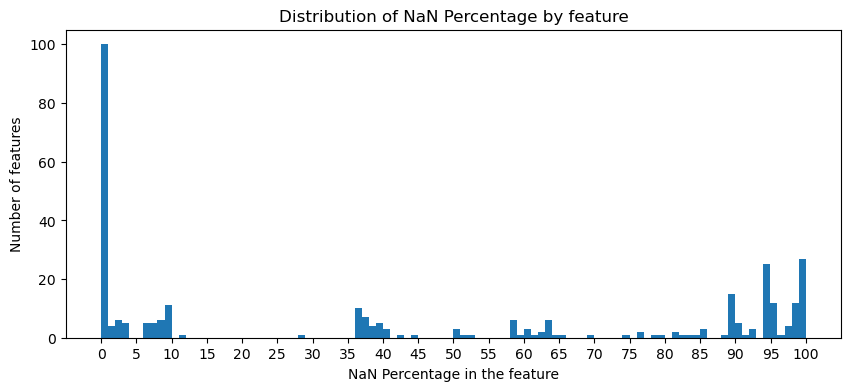

In [6]:
'''
We analyze the percentage of NaN values in each feature to determine an appropriate cutoff threshold.
Features with too many NaN values are less useful, but we want to remove features aimlessly.
'''
# Plot the nan distribution
import matplotlib.pyplot as plt
 
nan_percentage_by_feature = (np.sum(np.isnan(x_tr), axis=0) / len(x_tr)) * 100
plt.figure(figsize=(10, 4))
plt.hist(nan_percentage_by_feature, bins=100)
plt.title("Distribution of NaN Percentage by feature")
plt.xlabel("NaN Percentage in the feature")
plt.ylabel("Number of features")
plt.xticks(np.arange(start=0, stop=101, step=5))
plt.show()

In [7]:
"""
We analyze the percentage of NaN values in each feature to determine an appropriate cutoff threshold.
Features with too many NaN values are less useful, but we don’t want to remove too many features.

number of features left for each threshold value:
   5% nan: 115 -> 35% of features left
  50% nan: 174 -> 54%
  65% nan: 194 -> 60%
  90% nan: 222 -> 69%
we pick a threshold of 50% for now.
TODO: test difference in accuracy with different thresholds {5, 50, 65, 90}%
"""

MAX_NAN_PERCENTAGE = 50

def filter_features_with_too_many_nans(x_tr, x_te, threshold):
    """
    Modifies the passed dataset to remove features (columns) with more than a certain percentage of nan values
    Args:
        x_tr: the train dataset, (N, D) array
        x_te: the test dataset, (N_test, D) array
        threshold: max percentage of nan values to tolerate in a feature (column), integer between 0 and 100

    Returns:
        x_tr: the modified train dataset, (N, k), with k the number of remaining features (k <= D)
        x_te: the modified test dataset, (N_test, k), with k the number of remaining features (k <= D)
    """
    # Count the percentage of NaN values per feature
    nan_percentage_by_feature = (np.sum(np.isnan(x_tr), axis=0) / len(x_tr)) * 100
    
    mask = nan_percentage_by_feature < threshold
    # So we get rid of the features with more than MAX_NAN_PERCENTAGE % of NaN values
    x_tr = x_tr.copy()[:, mask]
    x_te = x_te.copy()[:, mask]
    from_nan_filtered_to_original_features = np.where(mask)[0]
    return x_tr, x_te, from_nan_filtered_to_original_features

x_tr, x_te, from_nan_filtered_to_original_features = filter_features_with_too_many_nans(x_tr, x_te, MAX_NAN_PERCENTAGE)

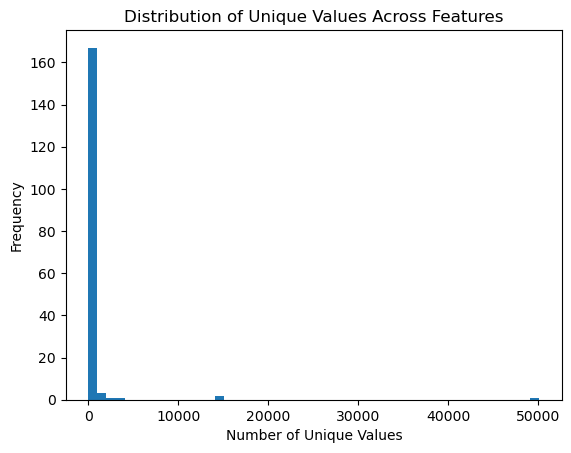

In [8]:
# Our objective is to build a mask to separate numerical and co (categorical/ordinal) data. 
# First we explore the data to see what is the maximum number of unique values for a co feature.

# Compute and plot the distribution of unique values 
unique_counts_and_indices = np.array([[len(np.unique(x_tr[:, i])),i] for i in range(x_tr.shape[1])])
unique_counts = unique_counts_and_indices[:,0]

plt.hist(unique_counts, bins=50) # Naive visualization, just to have an idea
plt.xlabel('Number of Unique Values')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Values Across Features')
plt.show()

# We consider that a feature with less than 10 values can be considered categorical/ordinal (co),
# and one with more than distinct 60 values is surely numerical (think about a human having to
# pick 100 options in a survey)

# Our goal is to find the co feature with the most distinct values to use it as a threshold
unique_counts_and_indices_refined = unique_counts_and_indices[(unique_counts_and_indices[:,0] > 10) & (unique_counts_and_indices[:,0] < 60)]
# We get back the original indexes of our x_tr to link our findings to the original feature indices
indices_to_consider = from_nan_filtered_to_original_features[unique_counts_and_indices_refined[:,1]]

In [9]:
x_label = np.array(["_STATE", "FMONTH", "IDATE", "IMONTH", "IDAY", "IYEAR", "DISPCODE", "SEQNO", "_PSU", "CTELENUM", "PVTRESD1", "COLGHOUS", "STATERES", "CELLFON3", "LADULT", "NUMADULT", "NUMMEN", "NUMWOMEN", "CTELNUM1", "CELLFON2", "CADULT", "PVTRESD2", "CCLGHOUS", "CSTATE", "LANDLINE", "HHADULT", "GENHLTH", "PHYSHLTH", "MENTHLTH", "POORHLTH", "HLTHPLN1", "PERSDOC2", "MEDCOST", "CHECKUP1", "BPHIGH4", "BPMEDS", "BLOODCHO", "CHOLCHK", "TOLDHI2", "CVDSTRK3", "ASTHMA3", "ASTHNOW", "CHCSCNCR", "CHCOCNCR", "CHCCOPD1", "HAVARTH3", "ADDEPEV2", "CHCKIDNY", "DIABETE3", "DIABAGE2", "SEX", "MARITAL", "EDUCA", "RENTHOM1", "NUMHHOL2", "NUMPHON2", "CPDEMO1", "VETERAN3", "EMPLOY1", "CHILDREN", "INCOME2", "INTERNET", "WEIGHT2", "HEIGHT3", "PREGNANT", "QLACTLM2", "USEEQUIP", "BLIND", "DECIDE", "DIFFWALK", "DIFFDRES", "DIFFALON", "SMOKE100", "SMOKDAY2", "STOPSMK2", "LASTSMK2", "USENOW3", "ALCDAY5", "AVEDRNK2", "DRNK3GE5", "MAXDRNKS", "FRUITJU1", "FRUIT1", "FVBEANS", "FVGREEN", "FVORANG", "VEGETAB1", "EXERANY2", "EXRACT11", "EXEROFT1", "EXERHMM1", "EXRACT21", "EXEROFT2", "EXERHMM2", "STRENGTH", "LMTJOIN3", "ARTHDIS2", "ARTHSOCL", "JOINPAIN", "SEATBELT", "FLUSHOT6", "FLSHTMY2", "IMFVPLAC", "PNEUVAC3", "HIVTST6", "HIVTSTD3", "WHRTST10", "PDIABTST", "PREDIAB1", "INSULIN", "BLDSUGAR", "FEETCHK2", "DOCTDIAB", "CHKHEMO3", "FEETCHK", "EYEEXAM", "DIABEYE", "DIABEDU", "CAREGIV1", "CRGVREL1", "CRGVLNG1", "CRGVHRS1", "CRGVPRB1", "CRGVPERS", "CRGVHOUS", "CRGVMST2", "CRGVEXPT", "VIDFCLT2", "VIREDIF3", "VIPRFVS2", "VINOCRE2", "VIEYEXM2", "VIINSUR2", "VICTRCT4", "VIGLUMA2", "VIMACDG2", "CIMEMLOS", "CDHOUSE", "CDASSIST", "CDHELP", "CDSOCIAL", "CDDISCUS", "WTCHSALT", "LONGWTCH", "DRADVISE", "ASTHMAGE", "ASATTACK", "ASERVIST", "ASDRVIST", "ASRCHKUP", "ASACTLIM", "ASYMPTOM", "ASNOSLEP", "ASTHMED3", "ASINHALR", "HAREHAB1", "STREHAB1", "CVDASPRN", "ASPUNSAF", "RLIVPAIN", "RDUCHART", "RDUCSTRK", "ARTTODAY", "ARTHWGT", "ARTHEXER", "ARTHEDU", "TETANUS", "HPVADVC2", "HPVADSHT", "SHINGLE2", "HADMAM", "HOWLONG", "HADPAP2", "LASTPAP2", "HPVTEST", "HPLSTTST", "HADHYST2", "PROFEXAM", "LENGEXAM", "BLDSTOOL", "LSTBLDS3", "HADSIGM3", "HADSGCO1", "LASTSIG3", "PCPSAAD2", "PCPSADI1", "PCPSARE1", "PSATEST1", "PSATIME", "PCPSARS1", "PCPSADE1", "PCDMDECN", "SCNTMNY1", "SCNTMEL1", "SCNTPAID", "SCNTWRK1", "SCNTLPAD", "SCNTLWK1", "SXORIENT", "TRNSGNDR", "RCSGENDR", "RCSRLTN2", "CASTHDX2", "CASTHNO2", "EMTSUPRT", "LSATISFY", "ADPLEASR", "ADDOWN", "ADSLEEP", "ADENERGY", "ADEAT1", "ADFAIL", "ADTHINK", "ADMOVE", "MISTMNT", "ADANXEV", "QSTVER", "QSTLANG", "MSCODE", "_STSTR", "_STRWT", "_RAWRAKE", "_WT2RAKE", "_CHISPNC", "_CRACE1", "_CPRACE", "_CLLCPWT", "_DUALUSE", "_DUALCOR", "_LLCPWT", "_RFHLTH", "_HCVU651", "_RFHYPE5", "_CHOLCHK", "_RFCHOL", "_LTASTH1", "_CASTHM1", "_ASTHMS1", "_DRDXAR1", "_PRACE1", "_MRACE1", "_HISPANC", "_RACE", "_RACEG21", "_RACEGR3", "_RACE_G1", "_AGEG5YR", "_AGE65YR", "_AGE80", "_AGE_G", "HTIN4", "HTM4", "WTKG3", "_BMI5", "_BMI5CAT", "_RFBMI5", "_CHLDCNT", "_EDUCAG", "_INCOMG", "_SMOKER3", "_RFSMOK3", "DRNKANY5", "DROCDY3_", "_RFBING5", "_DRNKWEK", "_RFDRHV5", "FTJUDA1_", "FRUTDA1_", "BEANDAY_", "GRENDAY_", "ORNGDAY_", "VEGEDA1_", "_MISFRTN", "_MISVEGN", "_FRTRESP", "_VEGRESP", "_FRUTSUM", "_VEGESUM", "_FRTLT1", "_VEGLT1", "_FRT16", "_VEG23", "_FRUITEX", "_VEGETEX", "_TOTINDA", "METVL11_", "METVL21_", "MAXVO2_", "FC60_", "ACTIN11_", "ACTIN21_", "PADUR1_", "PADUR2_", "PAFREQ1_", "PAFREQ2_", "_MINAC11", "_MINAC21", "STRFREQ_", "PAMISS1_", "PAMIN11_", "PAMIN21_", "PA1MIN_", "PAVIG11_", "PAVIG21_", "PA1VIGM_", "_PACAT1", "_PAINDX1", "_PA150R2", "_PA300R2", "_PA30021", "_PASTRNG", "_PAREC1", "_PASTAE1", "_LMTACT1", "_LMTWRK1", "_LMTSCL1", "_RFSEAT2", "_RFSEAT3", "_FLSHOT6", "_PNEUMO2", "_AIDTST3"])
x_label[indices_to_consider]

array(['_STATE', 'FMONTH', 'IMONTH', 'IDAY', 'NUMADULT', 'NUMWOMEN',
       'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'CHILDREN', 'INCOME2',
       'ALCDAY5', '_RAWRAKE', '_AGEG5YR', 'HTIN4', 'DROCDY3_', 'METVL11_',
       'METVL21_'], dtype='<U8')

```
co = categorical/ordinal, n = numerical
_STATE: 53 co
FMONTH: 12 
IMONTH: 12 
IDAY: 31 
PHYSHLTH: 32 
MENTHLTH: 32 
POORHLTH: 32 
CHILDREN: 11
INCOME2: 11
HEIGHT3: 57 n
ALCDAY5: 38
FRUITJU1: 50 
FVBEANS: 49
FVGREEN: 56 wtf is this format 😂
FVORANG: 52
STRENGTH: 49
_AGEG5YR: 14
HTIN4: 32
HTM4: 46
DROCDY3_: 34
FTJUDA1_: 43
FRUTDA1_: 59 n
BEANDAY_: 42
GRENDAY_: 48
ORNGDAY_: 43
VEGEDA1_: 58 I honestly dont know
METVL11_: 29
METVL21_: 28
PAFREQ1_: 55
STRFREQ_: 44
```

--> The answer was right under our nose ! The co feature with the most distinct values is _STATE.

In [10]:
'''
After methodical data exploration and analysis, we observed that the co feature that had 
the most distinct values (53) was _STATE which is our first feature. 

We consider every feature that has 53 distinct values or less as categorical or ordinal, and every feature that has 54 values or more as numerical.
'''
THRESHOLD_CO = 53
indices_of_co_features = np.where(unique_counts_and_indices[:,0] <= THRESHOLD_CO)[0]
index_of_numerical_features = np.where(unique_counts_and_indices[:,0] > THRESHOLD_CO)[0]

Now that we have isolated co features from numerical features, we can
- Impute missing values represented by a nan correctly (ex: replace nan with mode if co, replace nan with mean if numerical)
- Encode correctly our co features by:
    - One hot encoding
    - Keeping the original feature to make sure we dont use the ordinality of the ordinal features, as we dont make a difference between ordinal and categorical features.


In [11]:
'''
Starting here, we assume that every unusable value is a nan.

How do we impute missing values ?
We can take two routes:
1) Univariate imputation of missing values (we only consider the values of the related feature to impute missing values)
    - For numerical features: We replace by the mean or the median 
    - For co features: We replace nan values by a unique value to distinguish them
2) Multivariate imputation of missing values (we take into account all of the features to impute missing values)
    - Multiple techniques exist (KNN based, regression based...)


You have to agree that option 2 has a lot more style (and relevance). But it could also be a pain to implement with numpy 
(one usually uses scikit learn for this purpose) and as we did not see anything in class, 
all that we do is extra so we will go the easy route (1) for now. 

todo can we try 2) Multivariate imputation
'''

def impute_nan_values(x_tr, x_te, num_indices, co_indices):
    """
    Modify the train and test dataset to replace nan values with non-nan values
    
    For numerical features (columns), we replace nan values by the median
    
    For categorical or ordinal (called “co”) features, we replace them by the maximum value + 1.
    It acts as a kind of new “nan category,” which we believe makes more sense than taking the feature’s mode
    Args:
        x_tr: the train dataset, (N, D) array
        x_te: the test dataset, (N_test, D) array
        num_indices: 1D array containing the indices of the numerical features
        co_indices: 1D array containing the indices of the categorical/ordinal features

    Returns:
        x_tr: the modified train dataset with no more nan values, (N, D) array
        x_te: the modified test dataset with no more nan values, (N_test, D) array
    """
    # For numerical features: replace nan with median (more robust to outliers)
    medians = np.nanmedian(x_tr[:, num_indices], axis=0)
    x_tr[:, num_indices] = np.nan_to_num(x_tr[:, num_indices], nan=medians)
    x_te[:, num_indices] = np.nan_to_num(x_te[:, num_indices], nan=medians)
    
    # For categorical/ordinal features: replace nan with maximum + 1
    maximums = np.nanmax(x_tr[:, co_indices], axis=0) + 1
    x_tr[:, indices_of_co_features] = np.nan_to_num(x_tr[:, co_indices], nan=maximums)
    x_te[:, indices_of_co_features] = np.nan_to_num(x_te[:, co_indices], nan=maximums)
    
    return x_tr, x_te

x_tr, x_te = impute_nan_values(x_tr, x_te, index_of_numerical_features, indices_of_co_features)

In [12]:
'''
Feature transformation

- For numerical features: We standardize by substracting the mean and dividing by the std (todo we can also normalize them, which is better ? (ex: search min max normalization))
- For co features: 
    1) We add the one hot encoding while also keeping the original feature (to keep relations of ordinality for ordinal features)
    2) Can we handle nan values this way ? We need to check the results. (todo give me your opinion) 
'''

def standardize_some_features(x_tr, x_te, features_mask): #todo change name
    """
    Modify the train and test dataset to standardize the specified features
    
    Args:
        x_tr: the train dataset, (N, D) array
        x_te: the test dataset, (N_test, D) array
        features_mask: boolean array of length D with True for the features (columns) to standardize

    Returns:
        x_tr: the modified train dataset with the specified features standardized, (N, D) array
        x_te: the modified test dataset with the specified features standardized, (N_test, D) array
    """
    means = np.mean(x_tr[:, features_mask], axis=0)
    stds = np.std(x_tr[:, features_mask], axis=0)
    stds = np.where(stds == 0, 1, stds)
    x_tr[:, features_mask] = (x_tr[:, features_mask] - means) / stds
    x_te[:, features_mask] = (x_te[:, features_mask] - means) / stds
    return x_tr, x_te

x_tr, x_te = standardize_some_features(x_tr, x_te, index_of_numerical_features)

def encode_categorical_ordinal_features(x_tr, x_te, indices_of_co_features):
    """
    Perform one-hot encoding of the categorical and ordinal features of the dataset
    
    Returns arrays of shape (N, k), with k = D + (number of possible values each co feature can take, summed over all co features)
    
    Args:
        x_tr: the train dataset, (N, D) array
        x_te: the test dataset, (N_test, D) array
        indices_of_co_features: array of integer indices pointing to the features (columns) that represent categorical/ordinal features
        
    Returns:
        x_tr: the modified train dataset with the specified features encoded, (N, k) array
        x_te: the modified test dataset with the specified features encoded, (N_test, k) array

    """
    merged_x = np.vstack((x_tr, x_te))
    result = []
    for x in [x_tr, x_te]:
        N = len(x)
        for idx in indices_of_co_features:
            unique_values = np.unique(merged_x[:, idx])
            one_hot_length = len(unique_values)
            one_hot_features = np.zeros((N, one_hot_length)) #todo say dtype is int ?
        
            # Here the objective is to go from the value to the index in the array of unique values
            val_to_index = {value: index for index, value in enumerate(unique_values)}
            
            for i in range(N):
                val = x[i, idx]
                val_index = val_to_index[val]
                one_hot_features[i, val_index] = 1
        
            # Add these new features to our x matrix
            x = np.hstack((x, one_hot_features))
    
        result.append(x)

    # We also standardize the original co features which can have funky values
    x_tr, x_te = standardize_some_features(result[0], result[1], indices_of_co_features)
    
    return x_tr, x_te
    
x_tr, x_te = encode_categorical_ordinal_features(x_tr, x_te, indices_of_co_features)

In [13]:
# We are now expecting no nan in our dataset whatsoever.
assert not np.isnan(x_tr).any()

In [14]:
'''
Detecting outliers on numerical features

We have already standardized the numerical features, hence their value is their Z-score that we do not have to compute
again. First, we analyse the values of the numerical components of the samples and we define a Z-score threshold of 3
beyond which they are considered as outliers. We now check for the presence of outliers in our numerical features.
'''

(np.abs(x_tr[:,index_of_numerical_features]) > 3).any()

True

In [15]:
'''
Handling outliers on numerical features

We define percentiles to floor and cap the numerical data in order to clean our data from unexpected outliers.
'''

def clip_numerical_features(x_tr, x_te, indices_num_feat, floor_p=10, cap_p=90):
    """
    Args:
        x_tr: numpy array of shape (N,D), D is the number of features.
        floor_p: percentile on which we floor the numerical features.
        cap_p: percentile on which we cap the numerical features.
        indices_num_feat: The indices of x_tr numerical features.
    Returns:
        x_tr: numpy array of shape (N,D), D is the number of features. Outliers have been clipped.
        x_te: numpy array of shape (N_test,D), D is the number of features. Outliers have been clipped.
    """
    floors = np.percentile(x_tr[:,indices_num_feat], floor_p, axis=0)
    caps = np.percentile(x_tr[:,indices_num_feat], cap_p, axis=0)
    x_tr[:, indices_num_feat] = np.clip(x_tr[:, indices_num_feat], floors, caps)
    x_te[:, indices_num_feat] = np.clip(x_te[:, indices_num_feat], floors, caps)
    return x_tr, x_te

x_tr, x_te = clip_numerical_features(x_tr, x_te, index_of_numerical_features)

# Outliers have been clipped and there is no Z-score with an absolute value higher than 3
assert not (np.abs(x_tr[:,index_of_numerical_features]) > 3).any()

### Feature Selection

Using a correlation matrix, we would capture pairwise correlation relationships but our dataset captures correlations involving the interaction between three or more variables (ex: dates) 
      

We can use another approach: We do a regularized logistic regression, which forces the model to give more weight to highly predictive features, and close to 0 weight to useless features (as the model tries to spare the amount of weight).

We train our model using all the features a first time, then compare the absolute values of the weights and get rid of the features that have an associated weight that has a low enough absolute value (they were not deemed predictive during the regularized regression)

As we have seen in ADA, the lower the absolute value of a weight, the less impact a change in the related input feature will have on the prediction.

In [16]:
def build_tx(x):
    """
    Builds a data matrix with a column of one’s to its left (for bias weights in our model)
    
    Args:
        x: the (N,D) data matrix

    Returns:
        a (N,D+1) array with the leftmost column filled with 1s
    """
    return np.c_[np.ones((x.shape[0], 1)), x]

In [17]:
def test_model(w, tx_test, y_test):
    """
    Generate predictions using the given decision boundary
    Args:
        w: weight vector of dimension D representing the decision boundary
        tx_test: data matrix of dimension (N,D)
        y_test: ground truth array of dimension N, corresponding to the N points in the data matrix

    Returns:
        test_f1: the F1 score attained by the model on this dataset
        test_accuracy: the accuracy attained by the model on this dataset
    """
    # Sigmoid gives a value between 0 and 1
    test_probs = sigmoid(tx_test @ w)
    # We round to the nearest to get our prediction in {0,1}
    # (which we will transform later into {-1,1} for submission
    test_preds = np.round(test_probs)
    test_error_rate = np.count_nonzero(y_test - test_preds) / len(y_test)
    test_accuracy = 1 - test_error_rate
    test_f1 = compute_f1_score(y_test, test_preds)

    return test_f1, test_accuracy

In [18]:
def plot_scores_against_features_kept(scores, percent_of_features_kept):
    """
    Plot graphs showing how the various scores of the model evolve as a function ef the
    percentage of most significant features we keep
    
    Args:
        scores: a dict mapping the human-readable name of the scores computed, to the array
            of values (length k) for this score for different values of the percentage of features kept
        percent_of_features_kept: an array of length k containing the different percentages of features
         kept, ordered the same ways as the corresponding way scores are ordered in the dict
    """
    for score_name, score_values in scores.items():
        plt.plot(percent_of_features_kept, score_values, marker='o')
        plt.xlabel("Percentage of features kept")
        plt.ylabel(score_name)
        plt.title(f"{score_name} as we keep more or less features")
        plt.xticks(percent_of_features_kept)
        plt.grid(True)
        plt.show()

In [19]:
def train_initial_model(y_tr, tx_train, lambda_, max_iter, gamma):
    """
    Train a regularized logistic regression model and plot the magnitudes (absolute values) of
    the components of the learned weight vector
    
    Args:
        y_tr: ground truth for the training dataset, array of dimension N
        tx_train: training dataset, array of dimension (N,D)
        lambda_: weight of the regularization term
        max_iter: number of gradient descent iterations to perform
        gamma: learning rate for the gradient descent

    Returns:
        w_abs: the absolute value of the learned weight vector
    """
    initial_w = np.zeros(tx_train.shape[1])
    w, loss = reg_logistic_regression(y_tr, tx_train, lambda_, initial_w, max_iter, gamma)

    # Plot the magnitude of the learned weights
    # We see that lots of features carry little weight in the predictions
    # So we will try removing the least important features
    w_abs = np.abs(w)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(w_abs)), w_abs)
    plt.xlabel("Index")
    plt.ylabel("Value of w abs")
    plt.title("Values in vector w")
    plt.show()
    
    return w_abs

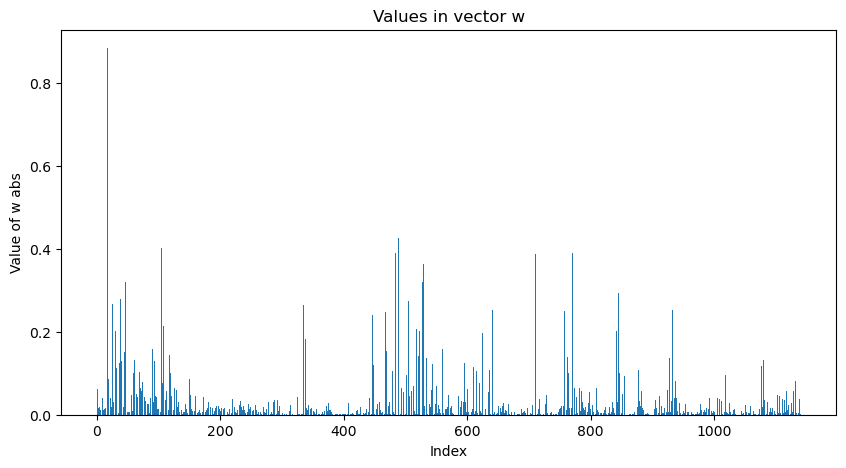

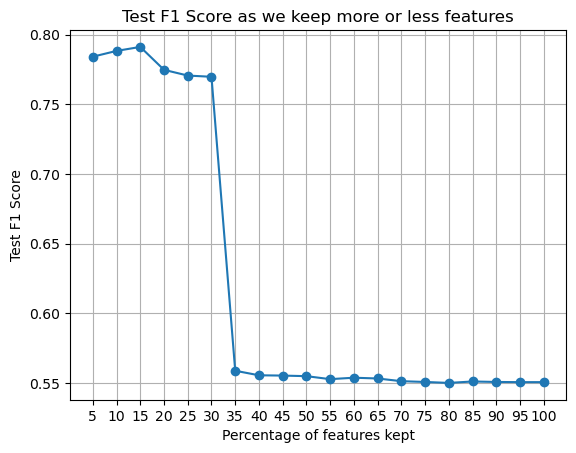

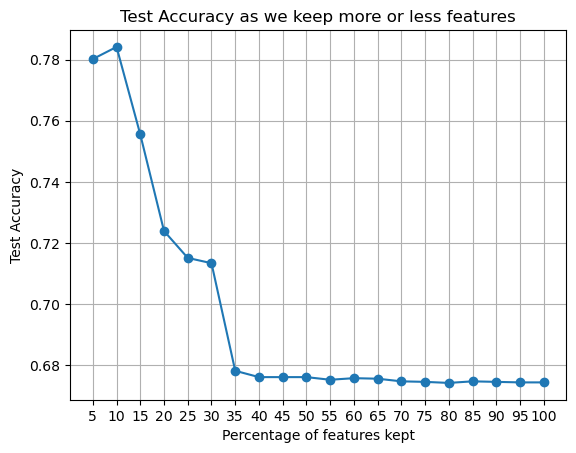

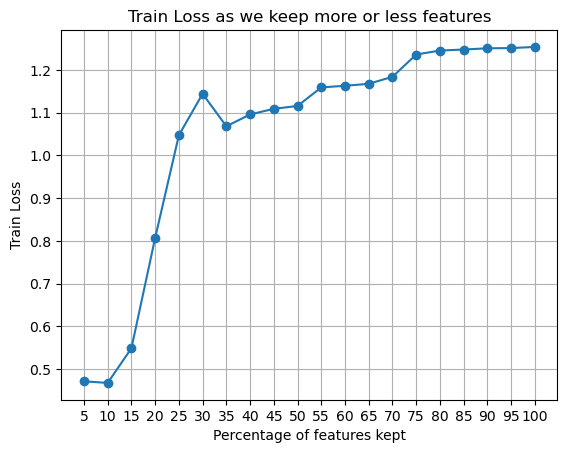

In [20]:
# We want to simplify the model, get better performance and reduce overfitting risk,
# by removing the features that do not contribute much to the predictions.

# So we only select the top P percent of features that contribute the most to the
# predictions, judging by the weight they have in the weight vector w we learned with
# logistic regression.

# The percentile P is the minimum weight value we require to keep P percent of the features.
# We select this P methodically by testing a wide range of possible such thresholds.


def split_train_data(x_tr, y_tr, train_percentage=0.9):
    """
    Split the training dataset into training and test datasets
    
    We only need this to find the best features to keep.
    For the hyperparameter selection we have proper cross-validation.
    
    Args:
        x_tr: the original training set, (N,D) array
        y_tr: the ground truth corresponding to the training set, (N) array
        train_percentage: percentage p of the dataset to keep for training float between 0.0 and 1.0
            a proportion of 1-p of the train set will be used as a test set

    Returns:
        X_train, X_test, y_train, y_test: the training and test sets, and their respective ground truth vectors
    """
    random_seed = 0 #TODO: use random seed
    np.random.seed(random_seed)

    N = x_tr.shape[0]
    indices = np.random.permutation(N)

    tr_set_size = int(N * train_percentage)
    tr_indices = indices[:tr_set_size]
    te_indices = indices[tr_set_size:]

    x_tr = x_tr.copy()
    X_train, X_test = x_tr[tr_indices], x_tr[te_indices]
    y_train, y_test = y_tr[tr_indices], y_tr[te_indices]

    return X_train, X_test, y_train, y_test

def select_most_significant_features():
    """
    Trains a first regularized logistic regression model, then tries to keep different percentages
    of the features that contribute the most to the predictions, in order to simplify the model by
    only keeping the most significant features.
    
    Returns:
        best_features_to_keep: array of integers specifying the indices of the feature selection that
            lead to the best f1 score in our tests
    """
    # Split the data so we can compute scores on a test set for each selection of features
    X_train, X_test, y_train, y_test = split_train_data(x_tr, y_tr, train_percentage=0.9)
    tx_train = build_tx(X_train)
    tx_test = build_tx(X_test)

    # We saw that a small lambda is better to allow for more variance in
    # weights, which makes picking the most important features easier
    max_iter = 100
    gamma = 0.5
    lambda_ = 0.0005

    # Train a first model using all the features
    w_abs = train_initial_model(y_train, tx_train, lambda_, max_iter, gamma)

    # We want to test keeping between 100% and 5% of the most significant features
    # This means having a threshold weight between the 0th and the 95th percentile of weight values
    percentiles_to_test = np.arange(0, 100, 5)
    threshold_w = [np.percentile(w_abs, p) for p in percentiles_to_test]
    scores = {
        'Test F1 Score': [],
        'Test Accuracy': [],
        'Train Loss': []
    }
    best_f1 = 0.0
    best_features_to_keep = None
    for t in threshold_w:
        features_to_keep = w_abs > t
        tx_train_filtered = tx_train[:, features_to_keep]
        tx_test_filtered = tx_test[:, features_to_keep]
        initial_w = np.zeros(tx_train_filtered.shape[1])
    
        w, train_loss = reg_logistic_regression(y_train, tx_train_filtered, lambda_, initial_w, max_iter, gamma)
    
        test_f1, test_accuracy = test_model(w, tx_test_filtered, y_test)
    
        # Store the results
        scores['Test F1 Score'].append(test_f1)
        scores['Test Accuracy'].append(test_accuracy)
        scores['Train Loss'].append(train_loss)
        # Store the feature selection if this gives the best f1 score so far
        if test_f1 > best_f1:
            best_features_to_keep = features_to_keep

    # We kept the top x% of features contributing most to predictions
    percent_of_features_kept = 100 - percentiles_to_test
    # Plot the result of our tests
    plot_scores_against_features_kept(scores, percent_of_features_kept)
    # Return the feature selection that gave the best F1 score
    return best_features_to_keep

best_features_to_keep = select_most_significant_features()


In [21]:
print(best_features_to_keep.shape)

(1142,)


# 3. Cross validation and model selection

In [22]:
from utilities.cross_validation import cross_validation_for_model_selection

In [23]:
fold_nums = 5
tx_train = build_tx(x_tr)[:, best_features_to_keep]
D = tx_train.shape[1]
models = []

## 3.1. Hyperparameter instantiation

### Regularized Logistic Regression

In [24]:
models += [dict(
    name='Regularized Logistic Regression',
    kind='logistic',
    parameters=dict(
        lambdas = 5 * 10 ** (-np.arange(5, 9, dtype=np.float64)),
        initial_w = np.zeros(D),
        max_its = 50 * np.arange(1, 21),
        gammas = [1, 1.3, 1.5]
    )
)]

### Logistic Regression

In [25]:
models += [dict(
    name='Logistic Regression',
    kind='logistic',
    parameters=dict(
        initial_w = np.zeros(D),
        max_its = 50 * np.arange(1, 21),
        gammas=[0.5, 1, 1.5]
    )
)]

### Least Squares Linear Regression

In [26]:
models += [dict(
    name='Least Squares Linear Regression',
    kind='least_squares',
    parameters=dict()
)]

### Least Squares Regularized Linear Regression

In [27]:
models += [dict(
    name='Least Squares Regularized Linear Regression',
    kind='least_squares',
    parameters=dict(
        lambdas=5 * 10 ** np.arange(5,10)
    )
)]

### MSE Linear Regression with GD

In [28]:
models += [dict(
    name='MSE Linear Regression with GD',
    kind='linear',
    parameters=dict(
        initial_w = np.zeros(D),
        max_its = 50 * np.arange(1, 21),
        gammas = [0.5, 0.7, 1, 1.3, 1.5]
    )
)]

## 3.2. Model selection

In [29]:
best_model, scores_by_model = cross_validation_for_model_selection(y_tr, tx_train, fold_nums=fold_nums, models=models, verbose=True)




Performing cross validation for Regularized Logistic Regression

Cross validating with	lambda_=5e-05	gamma=1
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.783559

Cross validating with	lambda_=5e-05	gamma=1.3
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.727771

Cross validating with	lambda_=5e-05	gamma=1.5
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.644114

Cross validating with	lambda_=4.9999999999999996e-06	gamma=1
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.783532

Cross validating with	lambda_=4.9999999999999996e-06	gamma=1.3
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.728090

Cross validating with	lambda_=4.9999999999999996e-06	gamma=1.5
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.644622

Cross validating with	lambda_=5e-07	gamma=1
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.783518

Cross validating with	lambda_=5e-07	gamma=1.3
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.728121

Cross v

/home/t/Documents/PCRAG/2 Casquettes/EPFL/Master/ML/projects/project1/ml-project-1-team-turing/utilities/linear_regression.py:30: RuntimeWarning: overflow encountered in matmul
  return 1 / (2 * len(y)) * e.T @ e
/home/t/Documents/PCRAG/2 Casquettes/EPFL/Master/ML/projects/project1/ml-project-1-team-turing/utilities/linear_regression.py:15: RuntimeWarning: overflow encountered in matmul
  e = y - tx @ w
/home/t/Documents/PCRAG/2 Casquettes/EPFL/Master/ML/projects/project1/ml-project-1-team-turing/utilities/linear_regression.py:16: RuntimeWarning: invalid value encountered in matmul
  return -(1 / len(y)) * tx.T @ e
/home/t/Documents/PCRAG/2 Casquettes/EPFL/Master/ML/projects/project1/ml-project-1-team-turing/utilities/linear_regression.py:15: RuntimeWarning: invalid value encountered in matmul
  e = y - tx @ w


k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.000000

Cross validating with	gamma=0.7
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.000000

Cross validating with	gamma=1
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.000000

Cross validating with	gamma=1.3
k=0	k=1	k=2	k=3	k=4	
	F1 score after 1000 iterations: 0.000000

Cross validating with	gamma=1.5
k=0	

/home/t/Documents/PCRAG/2 Casquettes/EPFL/Master/ML/projects/project1/ml-project-1-team-turing/utilities/linear_regression.py:29: RuntimeWarning: overflow encountered in matmul
  e = y - tx @ w
/home/t/Documents/PCRAG/2 Casquettes/EPFL/Master/ML/projects/project1/ml-project-1-team-turing/utilities/linear_regression.py:33: RuntimeWarning: overflow encountered in matmul
  preds = (x @ w > 0.5).astype(int)


k=1	k=2	k=3	k=4	

/home/t/Documents/PCRAG/2 Casquettes/EPFL/Master/ML/projects/project1/ml-project-1-team-turing/implementations.py:25: RuntimeWarning: overflow encountered in multiply
  w = w - gamma * gradient_mse(y, tx, w)
/home/t/Documents/PCRAG/2 Casquettes/EPFL/Master/ML/projects/project1/ml-project-1-team-turing/utilities/linear_regression.py:29: RuntimeWarning: invalid value encountered in matmul
  e = y - tx @ w
/home/t/Documents/PCRAG/2 Casquettes/EPFL/Master/ML/projects/project1/ml-project-1-team-turing/utilities/linear_regression.py:33: RuntimeWarning: invalid value encountered in matmul
  preds = (x @ w > 0.5).astype(int)



	F1 score after 1000 iterations: 0.000000


In [30]:
best_f1, best_hps, scores = scores_by_model[best_model] 
print("Best model is {:s} with an f1 score of {:.2f}\nBest hyperparameters:\n\t{}".format(best_model, best_f1, "\n\t".join(["{:10s} {}".format(k, v) for k, v in best_hps.items()])))

AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Best F1 score by model")
ax.set_ylabel("F1 Score")
ax.set_xlabel("Model Name")
width = 0.25
x = np.arange(len(scores_by_model))
ax.bar(x=x, height=[f1 for f1, _, _ in scores_by_model.values()], width=width, label="F1 score")
ax.set_xticks(x, [name.replace(" ", "\n") for name in scores_by_model.keys()], fontsize='x-small')
ax.legend(loc='upper right')

# 4. Train the final model and generate predictions for test.csv

In [32]:
# Load the dataset, without sub-sampling
x_tr_full_original, x_te_full_original, y_tr_full_original, tr_id_full, te_id_full = load_csv_data('dataset', sub_sample=False)
# Transform our y values from {-1,1} to {0,1} because that’s what logistic regression tests expect https://edstem.org/eu/courses/1605/discussion/134447
y_tr_full_original[y_tr_full_original == -1] = 0

In [ ]:
# Make a copy so we can just rerun this cell to start over instead of re-loading the dataset from disk, which is long
# rebalance the dataset
x_tr_full, y_tr_full = balance_dataset(x_tr_full_original, y_tr_full_original)
x_te_full = x_te_full_original

In [ ]:
# Preprocess the data
x_tr_full, x_te_full, _ = filter_features_with_too_many_nans(x_tr_full, x_te_full, MAX_NAN_PERCENTAGE)
x_tr_full, x_te_full = impute_nan_values(x_tr_full, x_te_full, index_of_numerical_features, indices_of_co_features)
x_tr_full, x_te_full = standardize_some_features(x_tr_full, x_te_full, index_of_numerical_features)
x_tr_full, x_te_full = encode_categorical_ordinal_features(x_tr_full, x_te_full)
x_tr_full, x_te_full = clip_numerical_features(x_tr_full, x_te_full, index_of_numerical_features)

In [ ]:
print(best_features_to_keep.shape)
print(x_tr_full.shape)
tx_train_full = build_tx(x_tr_full)[:, best_features_to_keep]

In [ ]:
# Train the final model with the best hyperparameters and the best feature selection
initial_w = np.zeros(tx_train_full.shape[1])
final_w, final_loss = reg_logistic_regression(y_tr_full, tx_train_full, best_hps.lambda_, initial_w, 100, best_hps.gamma)

In [ ]:
# Generate predictions and save them to .csv
# 
tx_test_full = build_tx(x_te_full)[:, best_features_to_keep]
# # Sigmoid gives a value between 0 and 1
test_probs_full = sigmoid(tx_test_full @ final_w)
# # We round to the nearest to get our prediction in {0,1}
test_preds_full = np.round(test_probs_full)
# # Transform them into {-1,1} for submission
test_preds_full[test_preds_full == 0] = -1
create_csv_submission(te_id_full, test_preds_full, 'full_test_preds.csv')

In [ ]:
# Running the pipeline on the full train set costs too much ram, my laptop can’t do it
# So we just train a final model, still with the subsampled dataset and the optimal parameters
# And we generate the final predictions with it

In [ ]:
initial_w = np.zeros(tx_train.shape[1])
final_w, final_loss = reg_logistic_regression(y_tr, tx_train, best_hps['lambda_'], initial_w, 100, best_hps['gamma'])

tx_test = build_tx(x_te)[:, best_features_to_keep]
# Sigmoid gives a value between 0 and 1
test_probs = sigmoid(tx_test @ final_w)
# We round to the nearest to get our prediction in {0,1}
test_preds = np.round(test_probs)
# Transform them into {-1,1} for submission
test_preds[test_preds == 0] = -1
create_csv_submission(te_id, test_preds, 'full_test_preds_subsampled.csv')